In [25]:
#Package Import
import pandas as pd
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
plt.style.use('seaborn-whitegrid')
os.chdir('C:\\Users\\pobryant\documents\heart')

In [26]:
#Data import and head of data
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Columns
1. age: age in years
2. sex(1 = male; 0 = female)
3. cp: chest pain type
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. cholserum: cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeakST: depression induced by exercise relative to rest
11. slopethe: slope of the peak exercise ST segment
12. ca: number of major vessels (0-3) colored by flourosopy
13. tha: l3 = normal; 6 = fixed defect; 7 = reversable defect
14. target: 1 or 0

Text(0,0.5,'Resting Blood Pressure')

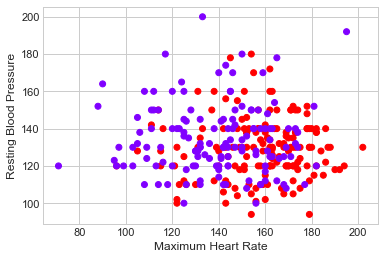

In [27]:
#Initial Scatterplot examing the relationship between Max Heart Rate and Resting Blood Pressure with class labels
plt.scatter(df['thalach'],df['trestbps'],c=df['target'],cmap='rainbow')
plt.xlabel('Maximum Heart Rate')
plt.ylabel('Resting Blood Pressure')

This plot shows the relationship between Maximum Heart Rate, Resting Blood Pressure, and our two classes of positive for heart disease and negative for heart disease. There does appear to be a visible trend  when heart rate and blood pressure are low heart disease is negative. When the opposite is true, heart disease tends to be positive.

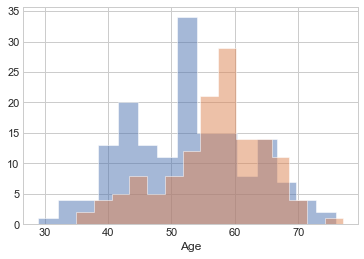

In [28]:
#Histograms examining the distribution of age by both classes
x1 = df['age'][df['target'] == 1]
x2 = df['age'][df['target'] == 0]

parameters = dict(histtype='stepfilled', alpha=0.5, bins=15)

plt.hist(x1, **parameters)
plt.hist(x2, **parameters)
plt.xlabel("Age");

This histogram gives us an idea of the distributions of age in our dataset and among the two classes. We can see that our dataset for the most part is middle aged averaging somewhere in the 50's. We can see that generally as age increases the percentage of those positive for heart disease increases and vice versa as age decreases. However, the distinction is not super clear, age would likely need to be paired with other features to determine if a patient is likely to have heart disease.

In [29]:
#Splitting data into train and test set
from sklearn.model_selection import train_test_split
X = df.iloc[:,:13]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [30]:
#Creating Naive Bayes model
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
labels = model.predict(X_test);

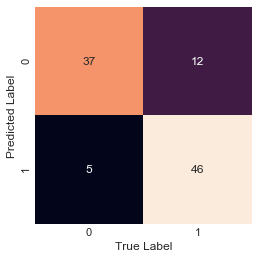

In [31]:
#Plotting confusion Matrix of Naive Bayes Model
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y_train.values), yticklabels=np.unique(y_train.values))
plt.xlabel('True Label')
plt.ylabel('Predicted Label');

The Naive Bayes classifier performed better than expected with an accuracy of around 83%. This model included all the features of the dataset with any preprocessing. The model definitely favored false negatives when predicting the incorrect response which is an issue for the applications of this dataset. For future more complex models we would like to take extra efforts to reduce the false negatives.

In [32]:
#Defining function to generate decision plot for random forest
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=30, cmap=cmap,clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,levels=np.arange(n_classes + 1) - 0.5,cmap=cmap,zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

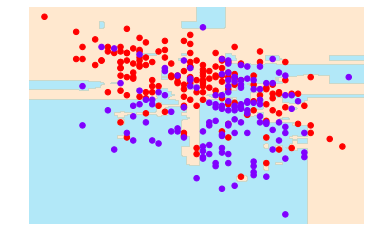

In [33]:
#Training random forest with default parameters and plotting decision cutoff areas
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
X = X.iloc[:,[0,7]]

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,random_state=1)
bag.fit(X, y)
visualize_classifier(bag, X, y)

This decision cutoff chart displays the decision cutoffs made by the random forest by coloring the background of the chart. This model was created with the default parameters and we can see it is overfitting by making decisions soley based on one observation. A model that is not overfit would make less specific decisions as to generalize better to new unseen data.

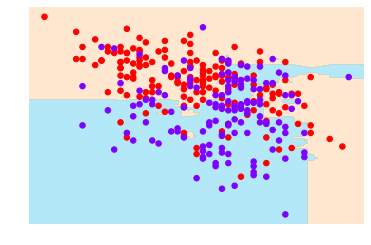

In [34]:
#Training forest with better parameters and plotting decision cutoff areas
tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators = 1000, max_samples=0.3,random_state=1)
bag.fit(X, y)
visualize_classifier(bag, X, y)

For this decision tree cutoff chart I changed the parameters to run with 10* as many estimators but I only let them sample 30% of the dataset. Essentially I gave a lot more estimators a superficial look at the dataset then averaged their decisions. This gave a much more generalized view of the data and thus much less overfitting. We can see in the chart that the decision boundaries are not specific to one point and capture general trends rather than isolated observations. The parameters used in this chart were either stepped down or up until I felt like the model had generalized well based on the visualization.

In [35]:
#Preparing data for Chi-Squared feature selection
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
array = df.values
X = array[:,0:13]
Y = array[:,13]

In [36]:
# Feature extraction
test = SelectKBest(score_func=chi2, k=6)
fit = test.fit(X, Y)

# Summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)

features = fit.transform(X)

[ 23.287   7.577  62.598  14.824  23.936   0.203   2.978 188.32   38.914
  72.644   9.804  66.441   5.792]


In [37]:
#Outputs of Chi-Squared Feature Ranking
dict(zip(df.columns,fit.scores_))

{'age': 23.286623985733986,
 'sex': 7.576834507647363,
 'cp': 62.59809791039943,
 'trestbps': 14.823924500200537,
 'chol': 23.936394475916686,
 'fbs': 0.20293368467281492,
 'restecg': 2.978270750988143,
 'thalach': 188.32047168970058,
 'exang': 38.91437697129396,
 'oldpeak': 72.64425301461824,
 'slope': 9.804095197255574,
 'ca': 66.4407651172357,
 'thal': 5.7918529711930535}

In [38]:
#Using RFE with logistic Regression for feature selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
nx = array[:,[0,3,4,7,9]]
rfe = RFE(model, 1)
fit = rfe.fit(nx, Y)
print("Num Features: %s" % (fit.n_features_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 1
Feature Ranking: [2 4 5 3 1]


In [39]:
#Outputs from RFE Ranking
columns = ['age','trestbps','chol','thalach','oldpeak']
dict(zip(columns,fit.ranking_))

{'age': 2, 'trestbps': 4, 'chol': 5, 'thalach': 3, 'oldpeak': 1}

Feature Selection Notes:
1. Goal -> to remove reundant or unimportant features in order to reduce the complexity of the model and improve accuracy. Ideally also will help with overfitting.
2. Chi Squared: Computes the chi squared statistic between each feature and the class. Measure the dependency between each feature and the class so it weeds out features that are indepedent of our class variable.
3. RFE: Iteratively creates models and determines the best or worst performing feature at each iterations based on the model accuracy. It then constructs models with the remaining features until all features have been explored.It ranks the features based on their order of elimination. It
4. Filter vs Wrapper Methods: Filter Methods do not incorporate machine learning models to determine the best features, Wrappers do. Wrapper methods work better when their is limited data because they are exhaustive.

Notes on our features:
1. Chi squared scored thalach the highest feature by a large margin and scored fbs as the worst feature.
2. RFE was run on all of the numeric features and scored oldpeak as the best feature and cholesterol as the worst. Chi squared also scored cholesterol fairly low.
3. The biggest discprency between the two is that RFE scored age as the second best numeric feature but chi-squared scored it fairly low. My theory is that age is a good predictor in tandem with other variables but not as good on its own. RFE is exhaustive so it would take this into consideration.


In [40]:
#Splitting data into test and train set for CNN
np.random.seed(13)
X = df.iloc[:,0:13].values
y = df.iloc[:,13].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Defining model layers using Keras
def build_model():
    model = Sequential()
    model.add(Dense(13, input_dim = 13))
    model.add(Dense(26, activation='relu'))
    model.add(Dense(26, activation='relu'))
    model.add(Dense(13, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [41]:
#Building model and fitting model to train set
keras_model = build_model()
keras_model.fit(X_train, y_train, epochs=200, batch_size=8, verbose=1)

Epoch 1/200
203/203 [==============================] - 0s 2ms/step - loss: 4.6221 - acc: 0.4433
Epoch 2/200
203/203 [==============================] - 0s 120us/step - loss: 2.3235 - acc: 0.4778
Epoch 3/200
203/203 [==============================] - 0s 120us/step - loss: 1.1857 - acc: 0.5714
Epoch 4/200
203/203 [==============================] - 0s 117us/step - loss: 0.7849 - acc: 0.6158
Epoch 5/200
203/203 [==============================] - 0s 117us/step - loss: 0.8128 - acc: 0.6502
Epoch 6/200
203/203 [==============================] - 0s 117us/step - loss: 0.7941 - acc: 0.6453
Epoch 7/200
203/203 [==============================] - 0s 122us/step - loss: 0.8088 - acc: 0.6108
Epoch 8/200
203/203 [==============================] - 0s 112us/step - loss: 1.1017 - acc: 0.5911
Epoch 9/200
203/203 [==============================] - 0s 117us/step - loss: 0.9222 - acc: 0.6108
Epoch 10/200
203/203 [==============================] - 0s 120us/step - loss: 0.6293 - acc: 0.6897
Epoch 11/200
203/203 

203/203 [==============================] - 0s 98us/step - loss: 0.7390 - acc: 0.6700
Epoch 84/200
203/203 [==============================] - 0s 110us/step - loss: 0.3869 - acc: 0.8128
Epoch 85/200
203/203 [==============================] - 0s 112us/step - loss: 0.3720 - acc: 0.8276
Epoch 86/200
203/203 [==============================] - 0s 108us/step - loss: 0.4063 - acc: 0.7783
Epoch 87/200
203/203 [==============================] - 0s 100us/step - loss: 0.4518 - acc: 0.7931
Epoch 88/200
203/203 [==============================] - 0s 103us/step - loss: 0.3886 - acc: 0.8177
Epoch 89/200
203/203 [==============================] - 0s 103us/step - loss: 0.3444 - acc: 0.8473
Epoch 90/200
203/203 [==============================] - 0s 112us/step - loss: 0.4802 - acc: 0.7931
Epoch 91/200
203/203 [==============================] - 0s 110us/step - loss: 0.3963 - acc: 0.8177
Epoch 92/200
203/203 [==============================] - 0s 100us/step - loss: 0.3994 - acc: 0.8079
Epoch 93/200
203/203 [==

203/203 [==============================] - 0s 110us/step - loss: 0.3675 - acc: 0.8177
Epoch 166/200
203/203 [==============================] - 0s 100us/step - loss: 0.3536 - acc: 0.8621
Epoch 167/200
203/203 [==============================] - 0s 105us/step - loss: 0.4058 - acc: 0.8325
Epoch 168/200
203/203 [==============================] - 0s 98us/step - loss: 0.3651 - acc: 0.8079
Epoch 169/200
203/203 [==============================] - 0s 100us/step - loss: 0.3222 - acc: 0.8867
Epoch 170/200
203/203 [==============================] - 0s 103us/step - loss: 0.3339 - acc: 0.8276
Epoch 171/200
203/203 [==============================] - 0s 103us/step - loss: 0.3526 - acc: 0.8571
Epoch 172/200
203/203 [==============================] - 0s 103us/step - loss: 0.3614 - acc: 0.8276
Epoch 173/200
203/203 [==============================] - 0s 100us/step - loss: 0.4121 - acc: 0.7980
Epoch 174/200
203/203 [==============================] - 0s 103us/step - loss: 0.4685 - acc: 0.7931
Epoch 175/200
2

In [42]:
#Evaluating model to train set
scores = keras_model.evaluate(X_train, y_train)
print("\n%s: %.2f%%" % (keras_model.metrics_names[1], scores[1]*100))

203/203 [==============================] - 0s 293us/step

acc: 86.21%


In [43]:
#Calculating FPR and TPR for ROC Curve Plot
y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.8669950738916257

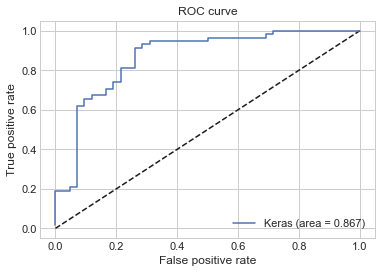

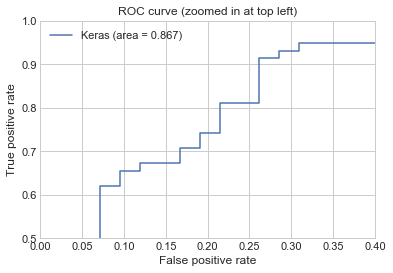

In [44]:
#Plotting ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.4)
plt.ylim(0.5, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

The above output is the ROC curve for the CNN we created above. Ideally in a ROC curve the closer the arc is to the top left corner of the chart the better the model performs as this means we are maximizing the true positive rate while minimizing our false positive rate. The ROC AUC (area under curve) is a numeric representation of the performance. Our AUC is 0.864 which is pretty good considering a AUC of 1 is the perfect scenario.

In [45]:
#Defining function to find the optimal cutoff point
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    fig, ax = plt.subplots()
    plt.plot(roc['tf'])
    plt.plot(roc['threshold'], color = 'red')
    plt.xlabel('1-False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    ax.set_xticklabels([])
    return list(roc_t['threshold']) 

[0.5370258688926697]

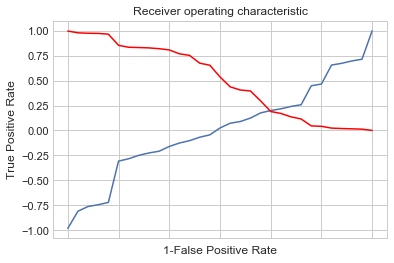

In [55]:
#Plotting optimal cutoff point
# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(y_test,y_pred_keras)
threshold

By Plotting the true positive rate agaisnt 1-false positive rate we can determine the optimal cutoff point for labeling the raw percentage output of our model with a class. In this plot we see the true positive rate which is also known as Sensitivity (True Positives/(True Positives + Fale Negatives)) and 1 - the false positive rate (False Positives/(False Positives + True Negatives)). By finding where these lines intersect we can maximize our accuracy and find the optimal decision point at which our model should operate. In this case our optimal cutoff is 0.5370258688926697.

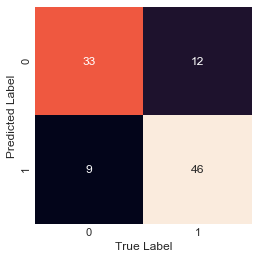

In [47]:
#Evaluating model to train set
scores = keras_model.predict(X_test)
#Determining the classes of test set based on model output and optimal cutoff value
y_pred = [1 if i > 0.5370258688926697 else 0 for i in scores]

#Generating confusion matrix for the optimal cutoff value
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('True Label')
plt.ylabel('Predicted Label');

The model performs fairly well using the optimal cutoff point to decide the classes of our outputs. Like the naive bayes model the number of false negatives is quite high so we would like to make efforts to reduce these.

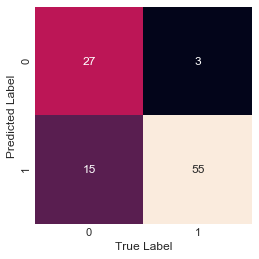

In [48]:
#Determining the class of test set based on new cutoff value lower to minimize false negatives
y_pred = [1 if i > 0.10 else 0 for i in scores]

#Generating confusion matrix for lower cutoff value
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('True Label')
plt.ylabel('Predicted Label');

By reducing the cutoff point drastically down to 0.10 we see much less false negatives. We decreased the false negatives from 12 down to just 3. This did increase the false positives quite a bit up to 15 but in general the model actually performs better. Even with the significant decrease in the cutoff value the model is still able to predict True negatives fairly well capturing a decent majority and not simply assigning positive classes to every observation in our test set.